In [ ]:
!pip install yfinance
!pip install seaborn
!pip install scikit-learn


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.2/59.2 KB 2.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 43.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.8/62.8 KB 6.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 111.2/111.2 KB 12.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.4/129.4 KB 14.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 112.2/112.2 KB 12.4 MB/s eta 0:00:00
  Attempting uninstall: requests
    Found existing installation: requests 2.25.1
    Uninstalling requests-2.25.1:
      Successfully uninstalled requests-2.25.1
  Attempting uninstall: html5lib
    Found existing installation: html5lib 1.0.1
    Uninstalling html5lib-1.0.1:
      Successfully uninstalled html5lib-1.0.1
  Attempting uninstall: beautifulsoup4
    Found existing installation: beautifulsoup4 4.6.3
   

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# Import necessary libraries
import os
import pandas as pd
from alpha_vantage.timeseries import TimeSeries




In [ ]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout


## 1, Load Data  
Here we choose to analyze the data from Apple Stock (AAPL) from 2010-01-01 to 2021-09-22 since Apple has their September event, and I want to find out the trend before that event.  


In [ ]:
# Define the stock symbol and date range
symbol = "AAPL"
start_date = "2010-01-01"
end_date = "2021-09-01"

# Fetch the historical stock prices
df = yf.download(symbol, start=start_date, end=end_date)


[*********************100%***********************]  1 of 1 completed


In [ ]:
df

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2010-01-04,7.622500,7.660714,7.585000,7.643214,6.505280,493729600
2010-01-05,7.664286,7.699643,7.616071,7.656429,6.516527,601904800
2010-01-06,7.656429,7.686786,7.526786,7.534643,6.412874,552160000
2010-01-07,7.562500,7.571429,7.466071,7.520714,6.401016,477131200
2010-01-08,7.510714,7.571429,7.466429,7.570714,6.443574,447610800
...,...,...,...,...,...,...
2021-08-25,149.809998,150.320007,147.800003,148.360001,147.064423,58991300
2021-08-26,148.350006,149.119995,147.509995,147.539993,146.251572,48597200
2021-08-27,147.479996,148.750000,146.830002,148.600006,147.302322,55802400


## 2, Preparing Data for Time Series Analysis

Here I compute several technical indicators for a financial time series data,clean uo the data by dealing with some of the NA's.  

First, I compute the 10-day moving average of the closing price, and store the result in a new column called "ma10"  

Then, I compute the 50-day moving average of the closing price, and store the result in a new column called "ma50"  

   
#### RSI:
I compute the Relative Strength Index (RSI) indicator. RSI is a momentum oscillator that measures the speed and change of price movements. It is calculated using the average gain and loss over a specified period of time, which in this case is 14 days.  
The calculation involves computing the difference between the current and previous closing prices, and then separating the gains and losses.  

#### MACD:  
MACD is a trend-following momentum indicator that shows the relationship between two exponential moving averages (EMA) of a security's price. In this case, the 12-day and 26-day EMAs of the closing price are computed, and the difference between them is stored in a new column called "macd". The signal line is then computed by taking the 9-day EMA of the MACD.  

#### Bollinger Bands indicator:  
Bollinger Bands are a type of statistical chart characterizing the prices and volatility over time of a financial instrument or commodity. In this case, the simple moving average (SMA) of the closing price over the last 20 days is computed, along with the standard deviation of the closing price over the same period. The upper and lower bands are then calculated by adding and subtracting two times the standard deviation from the SMA.

In [ ]:
# Compute moving averages
df['ma10'] = df['Close'].rolling(window=10).mean()
df['ma50'] = df['Close'].rolling(window=50).mean()

# Compute RSI (Relative Strength Index)
n = 14
delta = df['Close'].diff()
gain = delta.where(delta > 0, 0)
loss = -delta.where(delta < 0, 0)
avg_gain = gain.rolling(window=n).mean()
avg_loss = loss.rolling(window=n).mean()
rs = avg_gain / avg_loss
df['rsi'] = 100 - (100 / (1 + rs))

# Compute MACD (Moving Average Convergence Divergence)
ema12 = df['Close'].ewm(span=12, adjust=False).mean()
ema26 = df['Close'].ewm(span=26, adjust=False).mean()
df['macd'] = ema12 - ema26
df['signal'] = df['macd'].ewm(span=9, adjust=False).mean()

# Compute Bollinger Bands
n = 20
df['sma'] = df['Close'].rolling(window=n).mean()
df['std'] = df['Close'].rolling(window=n).std()
df['upper_band'] = df['sma'] + (df['std'] * 2)
df['lower_band'] = df['sma'] - (df['std'] * 2)

# Drop rows with missing values
df.dropna(inplace=True)

df

,Open,High,Low,Close,Adj Close,Volume,ma10,ma50,rsi,macd,signal,sma,std,upper_band,lower_band
Date,,,,,,,,,,,,,,,
2010-03-16,8.006429,8.035000,7.946786,8.016071,6.822624,446908000,7.879714,7.391336,90.199387,0.218543,0.157145,7.564411,0.368337,8.301085,6.827737
2010-03-17,8.032143,8.087500,7.973929,8.004286,6.812593,450956800,7.932536,7.398557,88.698407,0.216931,0.169102,7.602929,0.372217,8.347363,6.858494
2010-03-18,8.003571,8.035714,7.950357,8.023214,6.828707,342109600,7.982321,7.405893,87.806739,0.214706,0.178223,7.641714,0.373645,8.389003,6.894425
2010-03-19,8.028214,8.044286,7.901071,7.937500,6.755754,559445600,7.994107,7.413950,77.039146,0.203678,0.183314,7.678464,0.364198,8.406860,6.950068
2010-03-22,7.873929,8.071429,7.862500,8.026786,6.831745,456419600,8.014357,7.424071,79.575903,0.199839,0.186619,7.721911,0.350391,8.422693,7.021128
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-08-25,149.809998,150.320007,147.800003,148.360001,147.064423,58991300,148.824001,143.474400,53.953784,1.488006,1.715123,147.516000,1.748441,151.012882,144.019119
2021-08-26,148.350006,149.119995,147.509995,147.539993,146.251572,48597200,148.689000,143.822200,54.283948,1.321316,1.636361,147.611000,1.691847,150.994694,144.227307
2021-08-27,147.479996,148.750000,146.830002,148.600006,147.302322,55802400,148.639000,144.158401,57.233455,1.260220,1.561133,147.748000,1.653088,151.054177,144.441824


## 3, New Dataset Demonstration  

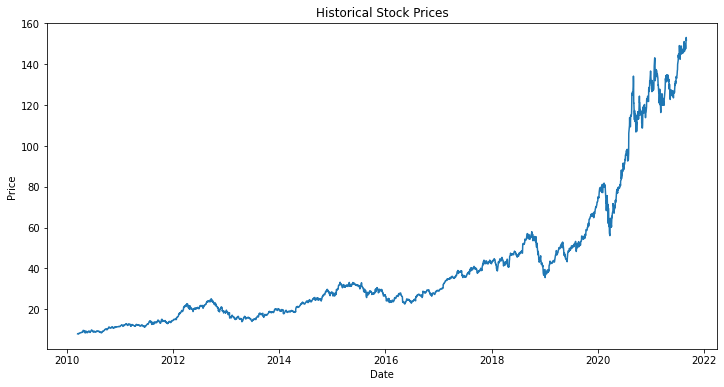

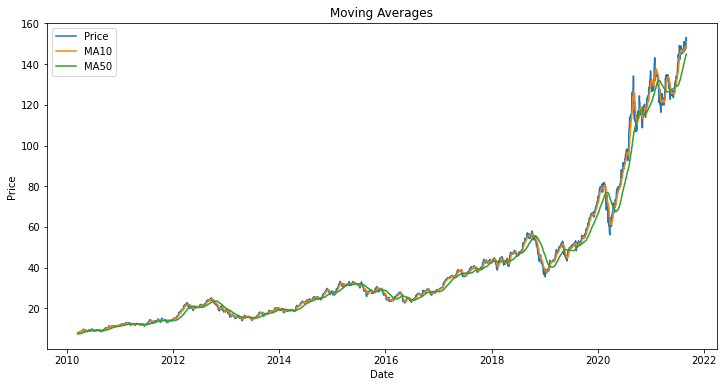

Text(0.5, 1.0, 'Relative Strength Index (RSI)')

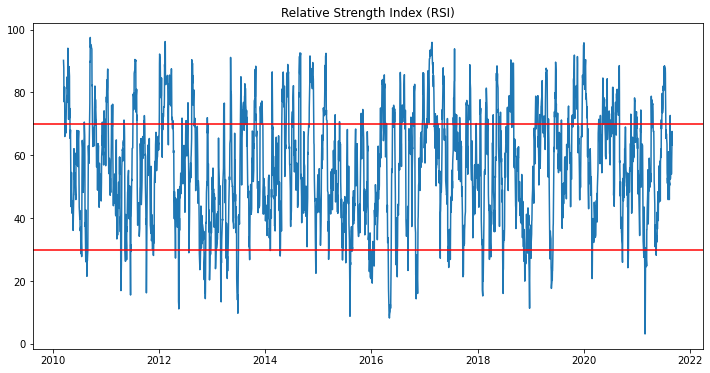

In [ ]:
# Plot the historical stock prices
plt.figure(figsize=(12, 6))
plt.plot(df['Close'])
plt.title('Historical Stock Prices')
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()

# Plot the moving averages
plt.figure(figsize=(12, 6))
plt.plot(df['Close'])
plt.plot(df['ma10'])
plt.plot(df['ma50'])
plt.legend(['Price', 'MA10', 'MA50'])
plt.title('Moving Averages')
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()

# Plot the RSI
plt.figure(figsize=(12, 6))
plt.plot(df['rsi'])
plt.axhline(y=30, color='r', linestyle='-')
plt.axhline(y=70, color='r', linestyle='-')
plt.title('Relative Strength Index (RSI)')


## 4, Modeling  
Here I used a Long Short-Term Memory (LSTM) neural network model, which is a type of recurrent neural network (RNN) often used for time series prediction.

In [ ]:
# Split data into train and test sets
train_size = int(len(df) * 0.8)
test_size = len(df) - train_size
train_data, test_data = df[:train_size], df[train_size:]

# Scale the data
scaler = MinMaxScaler(feature_range=(0, 1))
train_data = scaler.fit_transform(train_data)
test_data = scaler.transform(test_data)

lookback = 4

def create_dataset(dataset, lookback):
    dataX, dataY = [], []
    for i in range(len(dataset)-lookback-1):
        a = dataset[i:(i+lookback), :]
        dataX.append(a)
        dataY.append(dataset[i + lookback, 0])
    return np.array(dataX), np.array(dataY)


# Create feature and target sets for training
X_train, y_train = create_dataset(train_data, lookback)
X_test, y_test = create_dataset(test_data, lookback)

model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(units=1))

model.compile(optimizer='adam', loss='mean_squared_error')



I defined the LSTM model with the Sequential class from the Keras API. The model consists of three LSTM layers with 50 units each, and a dropout layer with a rate of 0.2 to prevent overfitting. The final layer is a dense layer with one unit, representing the predicted output. The model is then compiled using the Adam optimizer and the mean squared error loss function.

In [ ]:
X_train.shape


(2304, 4, 15)

In [ ]:
# Train model
model.fit(X_train, y_train, epochs=100, batch_size=64, verbose=2)



Epoch 1/100
36/36 - 7s - loss: 0.0472 - 7s/epoch - 189ms/step
Epoch 2/100
36/36 - 0s - loss: 0.0040 - 343ms/epoch - 10ms/step
Epoch 3/100
36/36 - 0s - loss: 0.0032 - 362ms/epoch - 10ms/step
Epoch 4/100
36/36 - 0s - loss: 0.0030 - 347ms/epoch - 10ms/step
Epoch 5/100
36/36 - 0s - loss: 0.0025 - 344ms/epoch - 10ms/step
Epoch 6/100
36/36 - 0s - loss: 0.0025 - 355ms/epoch - 10ms/step
Epoch 7/100
36/36 - 0s - loss: 0.0023 - 345ms/epoch - 10ms/step
Epoch 8/100
36/36 - 0s - loss: 0.0021 - 339ms/epoch - 9ms/step
Epoch 9/100
36/36 - 0s - loss: 0.0021 - 349ms/epoch - 10ms/step
Epoch 10/100
36/36 - 0s - loss: 0.0020 - 359ms/epoch - 10ms/step
Epoch 11/100
36/36 - 0s - loss: 0.0020 - 354ms/epoch - 10ms/step
Epoch 12/100
36/36 - 0s - loss: 0.0019 - 359ms/epoch - 10ms/step
Epoch 13/100
36/36 - 0s - loss: 0.0017 - 354ms/epoch - 10ms/step
Epoch 14/100
36/36 - 0s - loss: 0.0015 - 366ms/epoch - 10ms/step
Epoch 15/100
36/36 - 0s - loss: 0.0017 - 375ms/epoch - 10ms/step
Epoch 16/100
36/36 - 0s - loss: 0.001

## 5, Evaluation

In [ ]:
# Evaluate model
train_loss = model.evaluate(X_train, y_train, verbose=0)
test_loss = model.evaluate(X_test, y_test, verbose=0)
print('Train Loss:', train_loss)
print('Test Loss:', test_loss)



Train Loss: 0.00015013977827038616
Test Loss: 0.6612281203269958


The model is actually shockingly performing poorly, I might want to consider other approaches. Stock prediction is always a hard task to do, especially given the stock market is volatile in 2021.  
Also, it might be helpful to have other models to ensemble with LSTM so it has other validation in training. But this should not be used as investment tool under any circumstances.  
Though the outcome is not good, I still fit the data and has demonstration later.  


In [ ]:
X_test.shape

(573, 4, 15)

In [ ]:
# Predict future stock prices
future_prices = []
current = X_test[-1]
n_future = 35

for i in range(n_future):
  prediction = model.predict(current.reshape(1, lookback, X_train.shape[2]))
  future_prices.append(prediction[0][0])
  prediction_array = np.array([prediction[0][0]]*4).reshape(4,1) # Create a 4x1 array with the prediction value
  current_new = np.append(current, prediction_array, axis=1) # Append the prediction array to current array along axis 1
  current = current_new[:, 1:] # Drop the first column of current array


1/1 [==============================] - 0s 30ms/step


In [ ]:
test_data

array([[0.77996255, 0.78855607, 0.78630578, ..., 0.50731189, 0.92357953,
        0.83803558],
       [0.76285137, 0.75602248, 0.75411755, ..., 0.56608357, 0.9271854 ,
        0.82282027],
       [0.77138188, 0.77415189, 0.77607311, ..., 0.58560581, 0.92493062,
        0.81410962],
       ...,
       [2.80214907, 2.79570852, 2.7760164 , ..., 0.41202645, 2.86583213,
        2.92592924],
       [2.83265833, 2.88988237, 2.8113837 , ..., 0.49239993, 2.88574976,
        2.92099353],
       [2.9061213 , 2.87617348, 2.86463325, ..., 0.53349496, 2.89651998,
        2.91909087]])

In [ ]:
future_prices

[1.2684383,
 1.2524898,
 1.2432901,
 1.276617,
 1.2115273,
 1.1100588,
 1.1070776,
 1.1735198,
 1.1229529,
 1.1997321,
 1.2617013,
 1.273448,
 1.2267649,
 1.2334678,
 1.2060976,
 1.1430166,
 1.128032,
 1.1080174,
 1.1007707,
 1.0865651,
 1.0899646,
 1.1075273,
 1.1234003,
 1.1291854,
 1.1345162,
 1.1339108,
 1.1228297,
 1.109132,
 1.0973663,
 1.0838215,
 1.0713198,
 1.0651041,
 1.0635192,
 1.0662329,
 1.0702405]

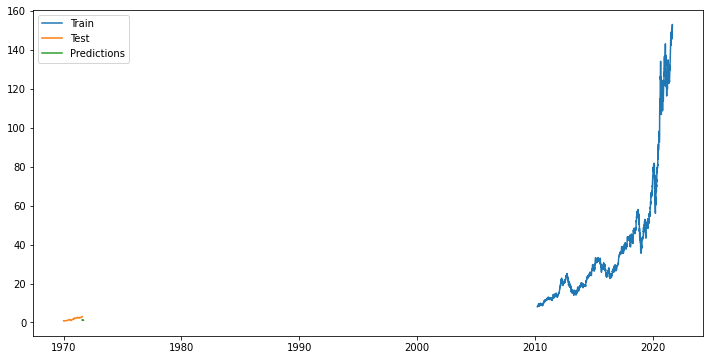

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['Close'])
plt.plot(np.arange(len(test_data)), test_data[:, -1])
plt.plot(np.arange(len(test_data), len(test_data)+n_future), future_prices)
plt.legend(['Train', 'Test', 'Predictions'])
